In [1]:
import numpy as np
import random
import string
from collections import deque
from collections import defaultdict
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from PIL import Image

In [2]:
class Node(object):
    def __init__(self, value=None, left=None, right=None):
        self.value = value
        self.left = None
        self.right = None

    def set_value(self, value):
        self.value = value
    def get_value(self):
        return self.value
    def set_left_child(self, left):
        self.left = left
    def set_right_child(self, right):
        self.right = right
    def get_left_child(self):
        return self.left
    def get_right_child(self):
        return self.right
    def has_left_child(self):
        return self.left != None
    def has_right_child(self):
        return self.right != None
    def is_leaf_node(self):
        return (self.left == None) and (self.right == None) and (self.value != None)

class Tree:
    def __init__(self):
        self.root = None
    def set_root(self, value):
        self.root = Node(value)
    def get_root(self):
        return self.root

In [3]:
class Encoder:
    def __init__(self,dataset):
        self.dataset = dataset
        
    def generate_unique_symbols(self,dataset):
        unique_symbols = set(dataset)
        return unique_symbols

    def compute_probabilities(self,unique_symbols):
        probabilities = {}
        for symbol in unique_symbols:
            probabilities[symbol] = self.dataset.count(symbol) / len(self.dataset)
            #create a list with the probabilities of each symbol and symbol as tuple 
        lst = [(probabilities[symbol], symbol) for symbol in unique_symbols]
        #sort the list by the probabilities
        lst.sort(reverse=True)
        return lst

    def sort_values(self,nodes_list, node):
        node_value, char1 = node.value
        index = 0
        max_index = len(nodes_list)
        while True:
            if index == max_index:
                nodes_list.append(node)
                return
            current_val, char2 = nodes_list[index].value
            if current_val <= node_value:
                nodes_list.insert(index, node)
                return
            index += 1

    def build_tree(self,probs):
        lst = probs
        nodes_list = []
        for node_value in lst:
            node = Node(node_value)
            nodes_list.append(node)

        while len(nodes_list) != 1:
            first_node = nodes_list.pop()
            second_node = nodes_list.pop()
            val1, char1 = first_node.value
            val2, char2 = second_node.value
            node = Node((val1 + val2, '#'))
            node.set_left_child(second_node)
            node.set_right_child(first_node)
            self.sort_values(nodes_list, node)

        root = nodes_list[0]
        tree = Tree()
        tree.root = root
        return tree

    def get_codes(self,root, bit_string=''):
        if root is None:
            return {}
        freq, characters = root.value
        char_dict = {}
        if root.is_leaf_node():
            char_dict[characters] = bit_string

        left_branch = self.get_codes(root.get_left_child(), bit_string + '0')

        for key, value in left_branch.items():
            char_dict[key] = left_branch[key]

        right_branch = self.get_codes(root.get_right_child(), bit_string + '1')

        for key, value in right_branch.items():
            char_dict[key] =  right_branch[key]

        return char_dict

    def bit_stream(self,dataset,code_book):
        Y = ''
        for char in dataset:
            Y += code_book[char]
        
        return Y
        
    #Encode the Huffman tree with in-order traversal, also known as the Code book
    def encoding_huffman_tree(self,root, s):
        if root:
            self.encoding_huffman_tree(root.get_left_child(), s)
            s += str(root.get_value()[0])+str(root.get_value()[1])+','
            self.encoding_huffman_tree(root.get_right_child(), s)
        return s

    def post_order_traversal(self,root,s):
        if root:
            self.post_order_traversal(root.get_left_child(),s)
            self.post_order_traversal(root.get_right_child(),s)
            if root.is_leaf_node():
                s += '1' + str(root.get_value()[1])
            else:
                s += '0'
        return s
    
    def print_binary_tree(self,root):
        if not root:
            return

        queue = deque([(root, 0)])
        current_depth = -1
        while queue:
            node, depth = queue.popleft()

            if current_depth != depth:
                print("")
                current_depth = depth

            print(node.value[1], end=" ")

            if node.left:
                queue.append((node.left, depth + 1))
            if node.right:
                queue.append((node.right, depth + 1))
    
class Decoder:
    def __init__(self,inorder_transversal,bit_stream,file_type='txt'):
        self.inorder_transversal = inorder_transversal
        self.bit_stream = bit_stream
        self.file_type = file_type
    
    def build_min_heap(self,inorder, start, end):
        if start > end:
            return None
        
        #find the index of maximum value in the inorder transversal from start to end
        max_index = start
        for i in range(start, end+1):
            if inorder[i].get_value()[0] > inorder[max_index].get_value()[0]:
                max_index = i

        root = inorder[max_index]
        if start == end:
            return root
        
        root.set_left_child(self.build_min_heap(inorder, start, max_index-1))
        root.set_right_child(self.build_min_heap(inorder, max_index+1, end))

        return root
        
    def reconstruct_huffman_tree(self,s):
        index = -1 if self.file_type=='txt' else -3
        nodes_list = []
        for node_value in s.split(','):
            if node_value[-1] == '#':
                node = Node((float(node_value[:-1]), node_value[-1]))
                nodes_list.append(node)
            else:
                node = Node((float(node_value[:index]), node_value[index:]))
                nodes_list.append(node)

        root = self.build_min_heap(nodes_list, 0, len(nodes_list)-1)
        tree = Tree()
        tree.root = root

        return tree
        
    def reconstruct_postorder_tree(self,post_order):
        #create a stack
        stack = []
        #create a root node
        i = 0
        while i < len(post_order):
            if post_order[i] == '1':
                #create a node
                node = Node((0,post_order[i+1]))
                #push the node to the stack
                stack.append(node)
                i += 1
            else:
                if len(stack) > 1:
                    r_node = stack.pop()
                    l_node = stack.pop()
                    root = Node((0,'#'))
                    root.set_left_child(l_node)
                    root.set_right_child(r_node)
                    stack.append(root)
                else:
                    break
            i += 1
            
        tree = Tree()
        tree.root = stack.pop()
    
        return tree

    def decode_data(self,Y,traversal='inorder'):
        tree = self.reconstruct_huffman_tree(self.inorder_transversal) if traversal == 'inorder' else self.reconstruct_postorder_tree(self.inorder_transversal)
        root = tree.root
        decoded_data = ''
        for bit in Y:
            if bit == '0':
                root = root.get_left_child()
            else:
                root = root.get_right_child()
            if root.is_leaf_node():
                decoded_data += root.value[1]
                root = tree.root
        return decoded_data

    def print_binary_tree(self,root):
        if not root:
            return

        queue = deque([(root, 0)])
        current_depth = -1
        while queue:
            node, depth = queue.popleft()

            if current_depth != depth:
                print("")
                current_depth = depth

            print(node.value[1], end=" ")

            if node.left:
                queue.append((node.left, depth + 1))
            if node.right:
                queue.append((node.right, depth + 1))

In [4]:
#Function for the Huffman encoder which would accept a .txt file as an input, and it would produce a compressed file .huf
def huffman_encoder(file,traversal='inorder'):
    file = open(file, "r")
    dataset = file.read()
    file.close()
    encoder_class = Encoder(dataset)
    unique_symbols = encoder_class.generate_unique_symbols(dataset)
    probabilities = encoder_class.compute_probabilities(unique_symbols)
    tree = encoder_class.build_tree(probabilities)
    code_book = encoder_class.get_codes(tree.root,'')
    Y = encoder_class.bit_stream(dataset, code_book)
    len_Y = len(Y)
    #padding the bit stream with 0's to make it a multiple of 8
    Y = Y + '0'*(8 - len(Y)%8)
    b = bytearray()
    for i in range(0, len(Y), 8):
        b.append(int(Y[i:i+8], 2))
    b = bytes(b)
    s = []
    encoder_class.encoding_huffman_tree(tree.root, s)
    encoded_tree = ''.join(s[:-1])

    #create a file with .huf extension and write the compressed data and store in bit format
    file = open(f"compressed_{file.name[:-4]}.huf", "wb")
    
    first_byte = len(encoded_tree).to_bytes(2, byteorder='big')
    file.write(first_byte)

    second_byte = encoded_tree.encode(encoding='utf-8')
    file.write(second_byte)
    
    third_byte = len_Y.to_bytes(2, byteorder='big')
    file.write(third_byte)

    rest_of_bytes = b
    file.write(rest_of_bytes)
    file.close()
    
    return file

In [5]:
def huffman_decoder(file,traversal='inorder'):

    file = open(file, "rb")

    first_byte = file.read(2)

    second_byte = file.read(int.from_bytes(first_byte, byteorder='big'))
    tree_traversal = second_byte.decode(encoding='utf-8')

    third_byte = file.read(2)
    len_Y = int.from_bytes(third_byte, byteorder='big')

    rest_of_bytes = file.read()
    bit_stream = ''
    for byte in rest_of_bytes:
        bit_stream += format(byte, '08b')
    bit_stream = bit_stream[:len_Y]
    file.close()

    #decode the Huffman tree
    decoder_class = Decoder(tree_traversal,bit_stream)
    decompressed_data = decoder_class.decode_data(bit_stream)

    file = open(f"decompressed_{file.name[11:-4]}.txt", "w")
    file.write(decompressed_data)
    file.close()

    return file

In [6]:
#Dataset1

def generate_dataset1(N):
    dataset = ''
    for i in range(N):
        dataset += random.choice(string.ascii_lowercase + string.digits)
    return dataset

In [7]:
encoding_time = []
def generate_files(list_of_N):
    for i in range(len(list_of_N)):
        temp_time = []
        for j in range(10):
            #open a file and write the dataset in dataset1 folder
            file = open(f"file_{j+1}_{list_of_N[i]}.txt", "w")
            dataset = generate_dataset1(list_of_N[i])
            file.write(dataset)
            file.close()
            start = time.time()
            huffman_encoder(f"file_{j+1}_{list_of_N[i]}.txt")
            end = time.time()
            temp_time.append(end-start)
        encoding_time.append(temp_time)

list_of_N = [50, 100, 500, 1000, 5000]
generate_files(list_of_N)

In [8]:
compression_factor = {}
for i in range(len(list_of_N)):
    temp_dict = {}
    for j in range(10):
        original_file = open(f"file_{j+1}_{list_of_N[i]}.txt", "r")
        compressed_file = open(f"compressed_file_{j+1}_{list_of_N[i]}.huf", "rb")
        original_file_size = os.path.getsize(f"file_{j+1}_{list_of_N[i]}.txt")
        compressed_file_size = os.path.getsize(f"compressed_file_{j+1}_{list_of_N[i]}.huf")
        temp_dict[f'{j+1}'] = original_file_size/compressed_file_size
        original_file.close()
        compressed_file.close()
    compression_factor[f'{list_of_N[i]}'] = temp_dict

In [9]:
compression_factor_df=pd.DataFrame(compression_factor)
compression_factor_df

,50,100,500,1000,5000
1,0.137741,0.196078,0.554324,0.810373,1.289657
2,0.155763,0.191205,0.522466,0.828500,1.303101
3,0.138889,0.198020,0.561798,0.828500,1.301406
4,0.132275,0.203252,0.558659,0.841751,1.289324
5,0.124378,0.198020,0.591716,0.848176,1.291322
6,0.143678,0.196464,0.545256,0.828500,1.290323
7,0.149701,0.212314,0.559284,0.846740,1.291656
8,0.142857,0.203666,0.551876,0.828500,1.276161
9,0.120482,0.186916,0.567537,0.807754,1.281066
10,0.134048,0.201613,0.559910,0.835422,1.278445


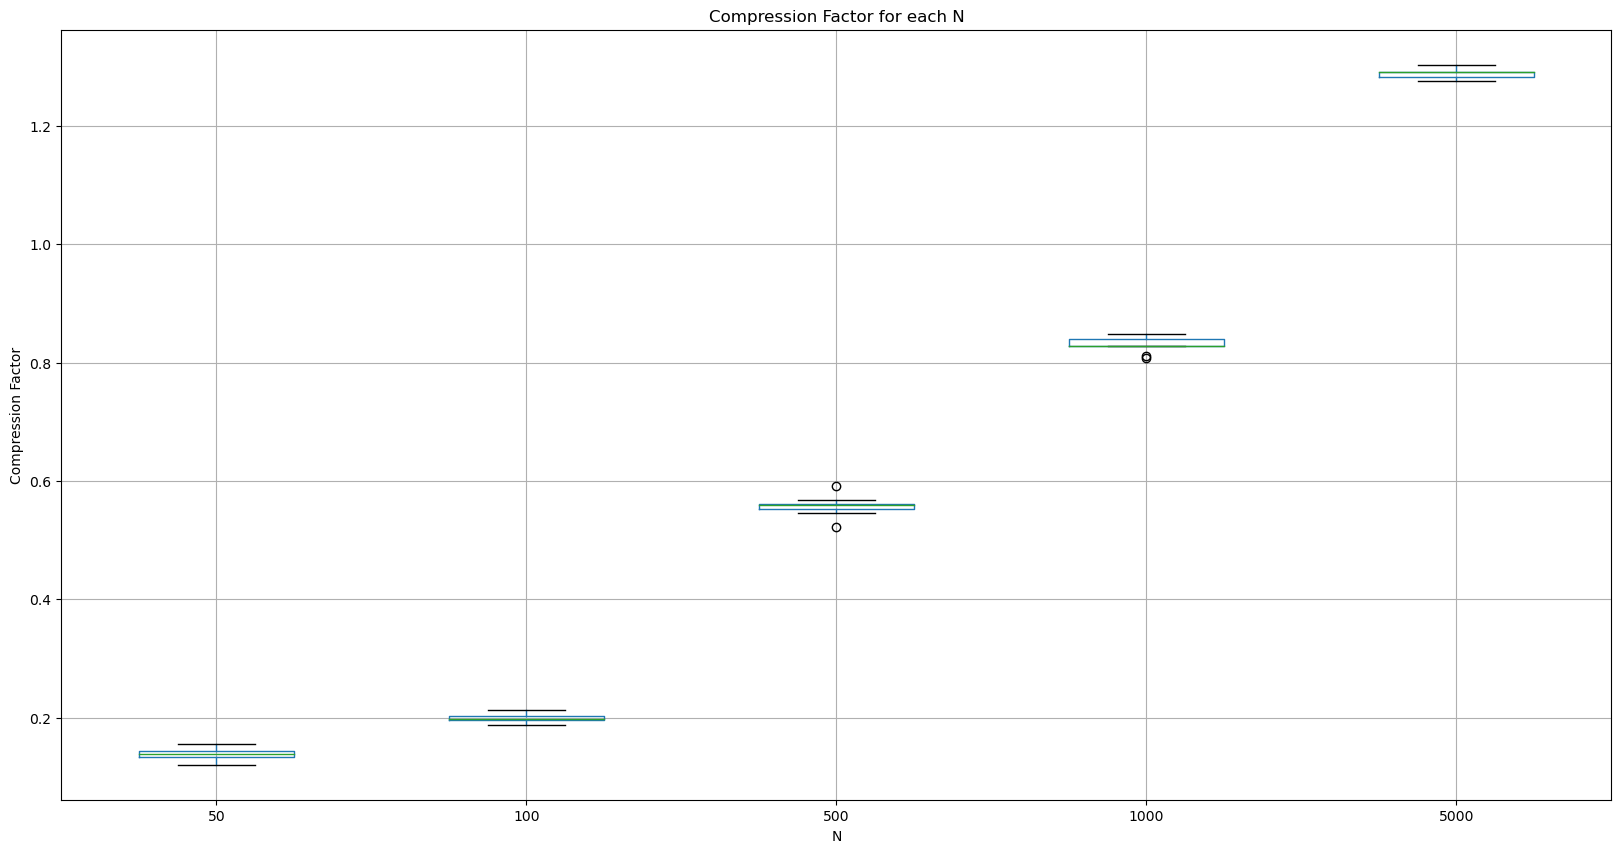

In [10]:
#Drow a boxplot to show the compression factor for each N
fig =plt.figure(figsize=(20,10),facecolor='white')
compression_factor_df.boxplot()
plt.title('Compression Factor for each N')
plt.xlabel('N')
plt.ylabel('Compression Factor')
plt.show()

In [11]:
decoding_time = []
for i in range(len(list_of_N)):
    temp_time = []
    for j in range(10):
        start = time.time()
        huffman_decoder(f"compressed_file_{j+1}_{list_of_N[i]}.huf")
        end = time.time()
        temp_time.append(end-start)
    decoding_time.append(temp_time)

In [12]:
def MSE(original_file, decoded_file):
    original_file = open(original_file, "r")
    decoded_file = open(decoded_file, "r")
    original_data = original_file.read()
    decoded_data = decoded_file.read()
    original_file.close()
    decoded_file.close()
    MSE = 0
    for i in range(len(original_data)):
        MSE += (ord(original_data[i]) - ord(decoded_data[i]))**2
    MSE = MSE/len(original_data)
    return MSE

MSE_list = []
for i in range(len(list_of_N)):
    temp_list = []
    for j in range(10):
        temp_list.append(MSE(f"file_{j+1}_{list_of_N[i]}.txt",f"decompressed_file_{j+1}_{list_of_N[i]}.txt"))
    MSE_list.append(temp_list)

#create a dataframe to store the MSE for each N
MSE_df = pd.DataFrame(MSE_list, columns = [f'file_{i+1}' for i in range(10)], index = [f'{list_of_N[i]}' for i in range(len(list_of_N))])
MSE_df

,file_1,file_2,file_3,file_4,file_5,file_6,file_7,file_8,file_9,file_10
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, 'Time (sec)')

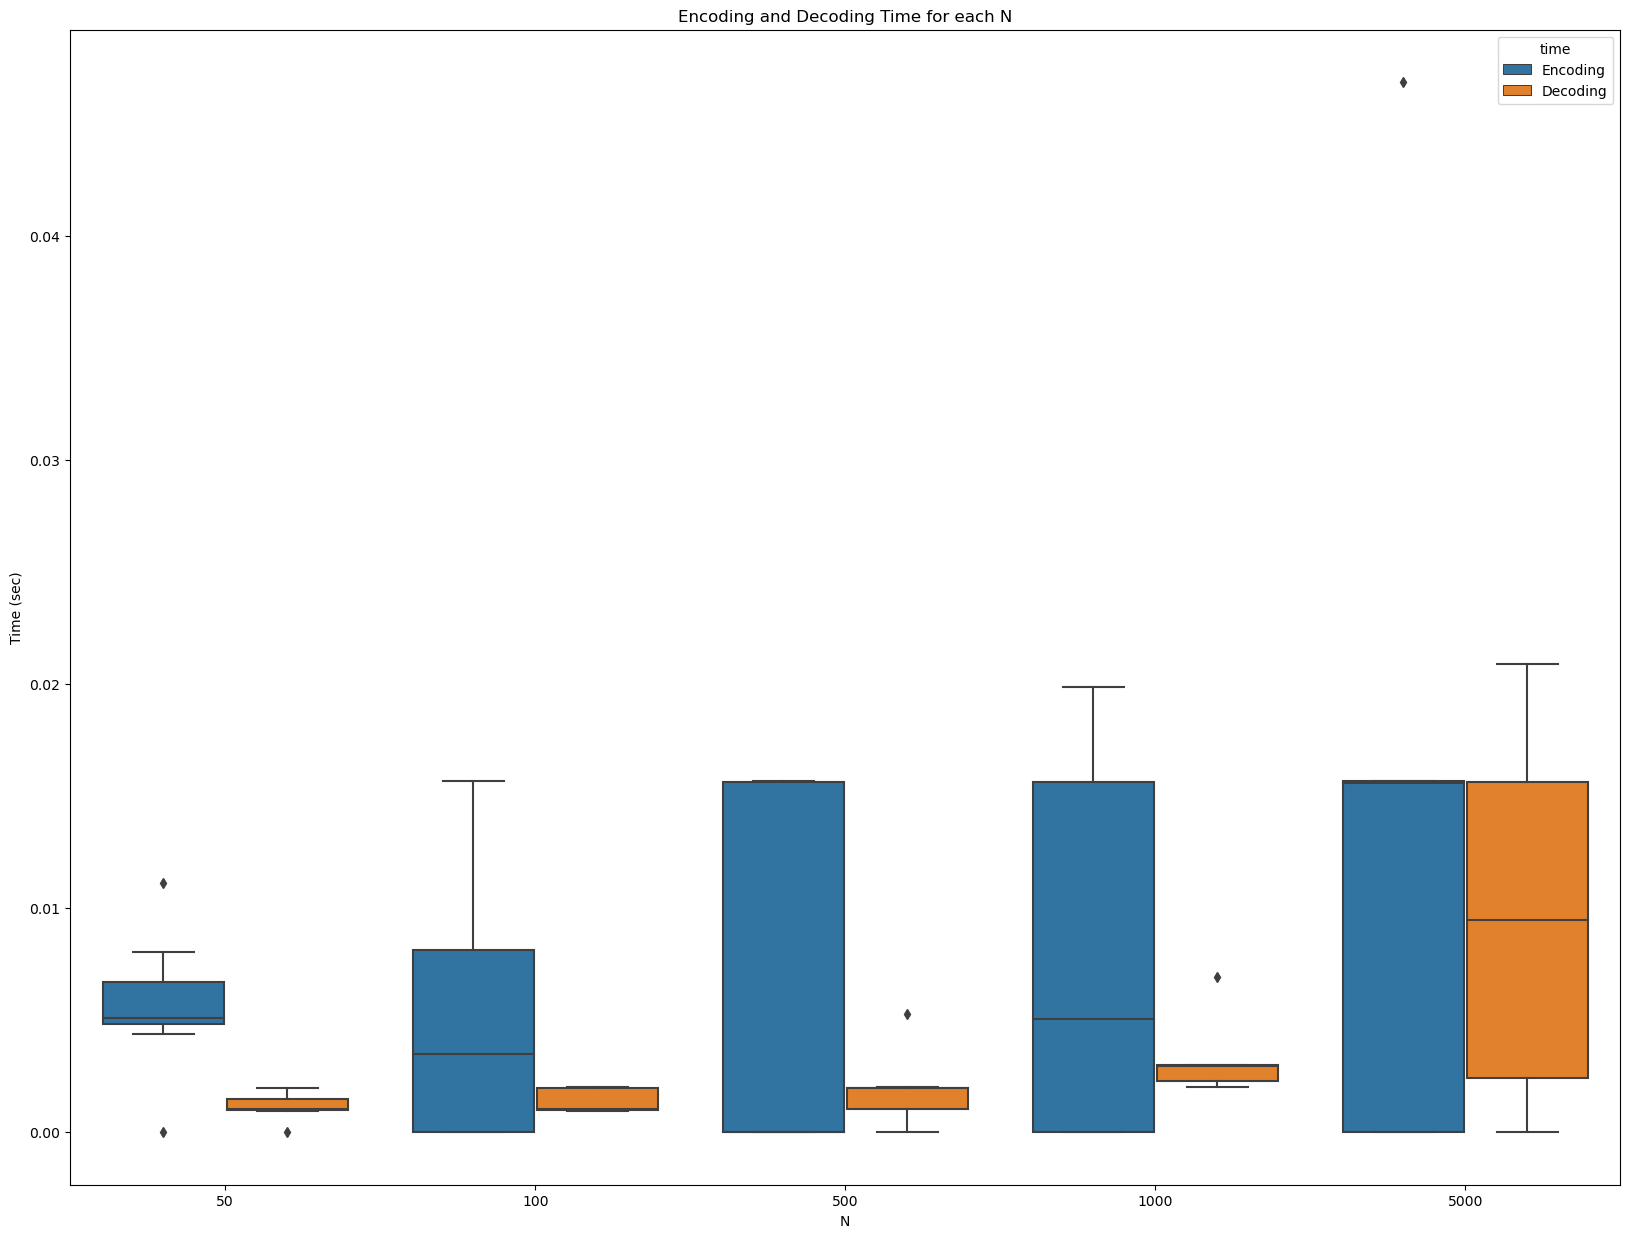

In [18]:
#Measure the time to encode and decode each file, and report the times separate as a notch-box plot for encoder and for decoder.
#Draw a boxplot to show the encoding time for each N on a single plot
encoding_time_df = pd.DataFrame(encoding_time, columns = [f'file_{i+1}' for i in range(10)], index = [f'{list_of_N[i]}' for i in range(len(list_of_N))])
decoding_time_df = pd.DataFrame(decoding_time, columns = [f'file_{i+1}' for i in range(10)], index = [f'{list_of_N[i]}' for i in range(len(list_of_N))])
encoding_time_df['time'] = 'Encoding'
decoding_time_df['time'] = 'Decoding'
encoding_time_df['N'] = list_of_N
decoding_time_df['N'] = list_of_N
time_df = pd.concat([encoding_time_df, decoding_time_df])

#create a dataframe having N and time as columns
time_df = time_df.melt(id_vars=['N', 'time'], var_name='file', value_name='time_taken')
plt.figure(figsize=(20,15),facecolor='white')
sns.boxplot(x='N', y='time_taken', hue='time', data=time_df)
plt.title('Encoding and Decoding Time for each N')
plt.xlabel('N')
plt.ylabel('Time (sec)')

In [19]:
#Dataset 2
from sklearn.datasets import fetch_olivetti_faces

faces , _ = fetch_olivetti_faces(return_X_y =True, shuffle =True, random_state = 42)
n_samples , n_features = faces.shape
print(faces.shape)

#rescale the data to [0,255]
faces = faces * 255
faces = faces.astype(int)

(400, 4096)


In [21]:
#store each image in a .bmp file
#Form a folder named olivetti in the main directory to avoid any error
for i in range(400):
    image = faces[i].reshape(64,64)
    image = Image.fromarray(image)
    image = image.convert('L')
    image.save(f"olivetti\image_{i+1}.bmp",format='BMP', bits=8)

In [22]:
def huffman_encoder_bmp(path):
    file = Image.open(path)
    image = np.array(file)
    file.close()
    image = image.flatten().tolist()
    for i in range(len(image)):
        image[i] = str(image[i])
        if len(image[i]) == 1:
            image[i] = '00' + image[i]
        elif len(image[i]) == 2:
            image[i] = '0' + image[i]
    
    encoder_class = Encoder(image)
    unique_symbols = encoder_class.generate_unique_symbols(image)
    probabilities = encoder_class.compute_probabilities(unique_symbols)
    tree = encoder_class.build_tree(probabilities)
    code_book = encoder_class.get_codes(tree.root,'')
    Y = encoder_class.bit_stream(image, code_book)
    len_Y = len(Y)
    #padding the bit stream with 0's to make it a multiple of 8
    Y = Y + '0'*(8 - len(Y)%8)
    b = bytearray()
    for i in range(0, len(Y), 8):
        b.append(int(Y[i:i+8], 2))
    b = bytes(b)
    s = []
    encoder_class.encoding_huffman_tree(tree.root, s)
    encoded_tree = ''.join(s[:-1])
    #create a file with .huf extension and write the compressed data and store in bit format
    file = open(f"olivetti\compressed_{path[9:-4]}.huf", "wb")

    first_byte = len(encoded_tree).to_bytes(2, byteorder='big')
    file.write(first_byte)

    second_byte = encoded_tree.encode(encoding='utf-8')
    file.write(second_byte)

    third_byte = len_Y.to_bytes(2, byteorder='big')
    file.write(third_byte)

    rest_of_bytes = b
    file.write(rest_of_bytes)
    file.close()
    
    return file

In [23]:
def huffman_decoder_bmp(file):
    #open the compressed file
    file = open(file, "rb")
    #read the first byte which is the number of Bytes which are used to storing the Huffman tree in its in-order traversal representation.
    first_byte = file.read(2)
    #read the second byte till the first byte which is the Huffman tree.
    second_byte = file.read(int.from_bytes(first_byte, byteorder='big'))
    inorder_transversal = second_byte.decode(encoding='utf-8')
    #read the third byte which is the number of Bytes which are used to store the coded bit stream Y.
    third_byte = file.read(2)
    len_Y = int.from_bytes(third_byte, byteorder='big')
    #read the rest of the bytes which is the coded bit stream Y converted in bit format from string.
    rest_of_bytes = file.read()
    bit_stream = ''
    for byte in rest_of_bytes:
        bit_stream += format(byte, '08b')
    bit_stream = bit_stream[:len_Y]
    file.close()

    #decode the Huffman tree
    decoder_class = Decoder(inorder_transversal,bit_stream,'img')
    decompressed_data = decoder_class.decode_data(bit_stream)
    decompressed_data = np.array([int(decompressed_data[i:i+3]) for i in range(0, len(decompressed_data), 3)])
    decompressed_data = decompressed_data.reshape(64,64)
    image = Image.fromarray(decompressed_data)
    image = image.convert('L')
    image.save(f"olivetti\decompressed_{file.name[20:-4]}.bmp",format='BMP', bits=8)

In [24]:
encoding_time = []
for i in range(400):
    start = time.time()
    huffman_encoder_bmp(f"olivetti\image_{i+1}.bmp")
    end = time.time()
    encoding_time.append(end-start)

In [25]:
#compute compression ratio
compression_ratio = []
for i in range(400):
    original_file_size = os.path.getsize(f"olivetti\image_{i+1}.bmp")
    compressed_file_size = os.path.getsize(f"olivetti\compressed_image_{i+1}.huf")
    compression_ratio.append(original_file_size/compressed_file_size)

compression_df = pd.DataFrame(compression_ratio, columns=['compression'])

C:\Users\Ajay Raj\AppData\Local\Temp\ipykernel_30972\3990315050.py:2: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  compression_df = compression_df.melt(var_name='img', value_name='compression')


Text(0, 0.5, 'compression ratio')

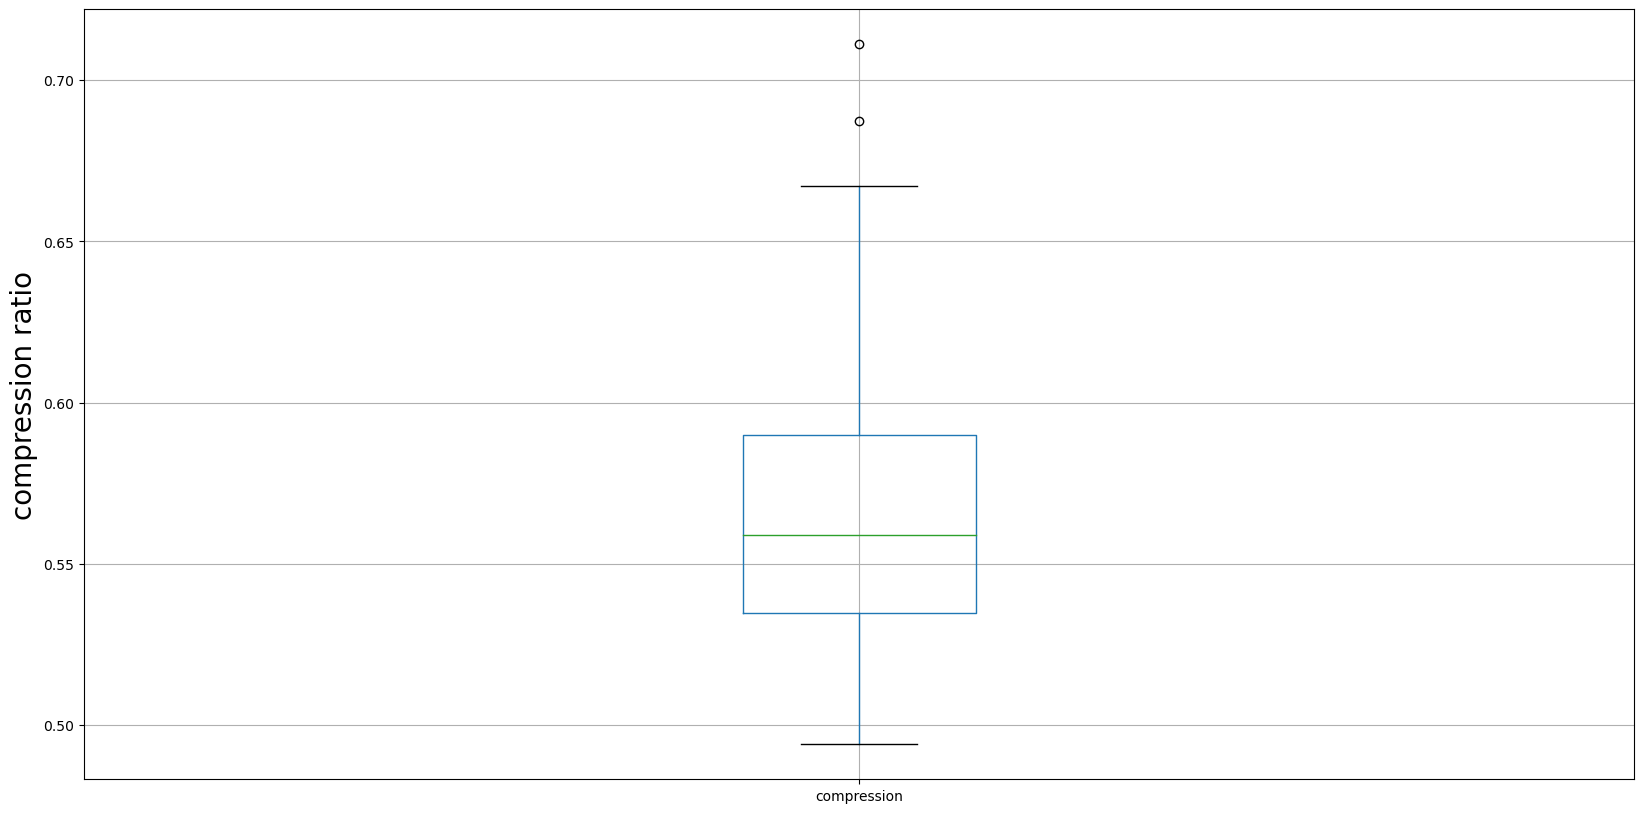

In [26]:
#boxplot of compression ratio
compression_df = compression_df.melt(var_name='img', value_name='compression')
compression_df.boxplot(column='compression', figsize=(20,10))
#label the y-axis
plt.ylabel('compression ratio', fontsize=20)

In [27]:
decoding_time = []
for i in range(400):
    start = time.time()
    huffman_decoder_bmp(f"olivetti\compressed_image_{i+1}.huf")
    end = time.time()
    decoding_time.append(end-start)

In [28]:
#MSE between original and decompressed images
MSE = []
for i in range(400):
    original = Image.open(f"olivetti\image_{i+1}.bmp")
    decompressed = Image.open(f"olivetti\decompressed_image_{i+1}.bmp")
    original = np.array(original)
    decompressed = np.array(decompressed)
    MSE.append(np.mean((original - decompressed) ** 2))

#make a dataframe having img and MSE as columns
MSE_df = pd.DataFrame(MSE, columns=['MSE'])
MSE_df

,MSE
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
395,0.0
396,0.0
397,0.0
398,0.0


In [29]:
#box plot of encoding and decoding time
encoding_time_df = pd.DataFrame(encoding_time, columns=['encoding_time'])
decoding_time_df = pd.DataFrame(decoding_time, columns=['decoding_time'])
#concatenate the two dataframes
time_df = pd.concat([encoding_time_df, decoding_time_df], axis=1)
time_df

,encoding_time,decoding_time
0,0.028368,0.020901
1,0.014451,0.022237
2,0.025191,0.018782
3,0.020637,0.017940
4,0.020727,0.010046
...,...,...
395,0.031242,0.015622
396,0.015622,0.031244
397,0.029886,0.015623
398,0.007565,0.031246


Text(0.5, 1.0, 'Notch-box plot of encoding and decoding time')

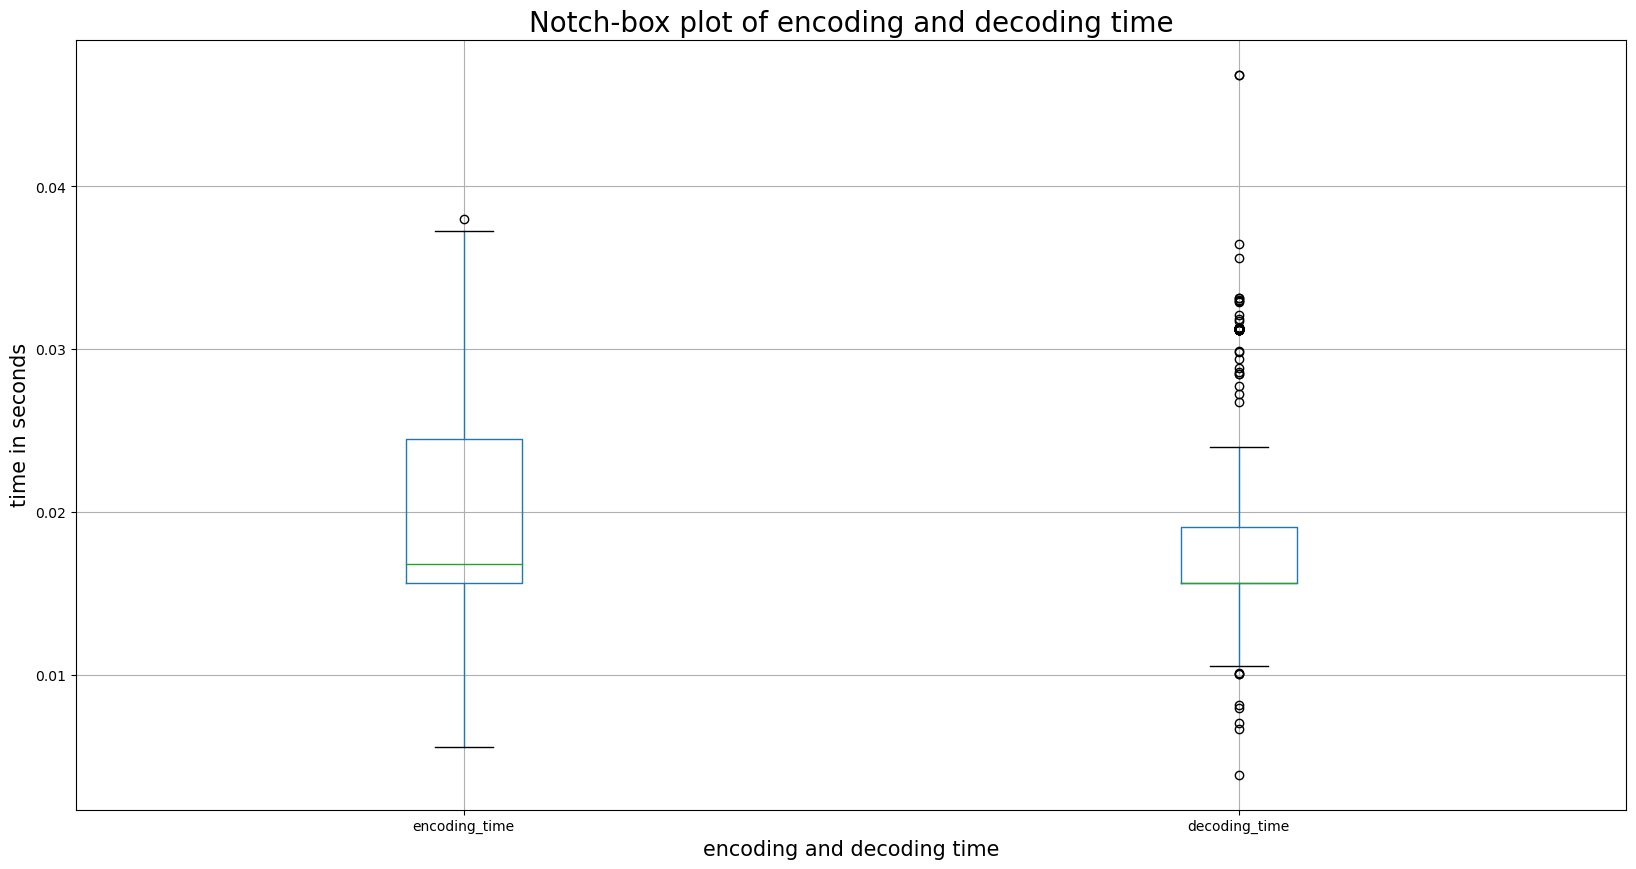

In [30]:
fig =plt.figure( figsize=(20,10),facecolor='white')
time_df.boxplot(column=['encoding_time', 'decoding_time'])
plt.xlabel('encoding and decoding time', fontsize=15)
plt.ylabel('time in seconds', fontsize=15)
plt.title('Notch-box plot of encoding and decoding time', fontsize=20)

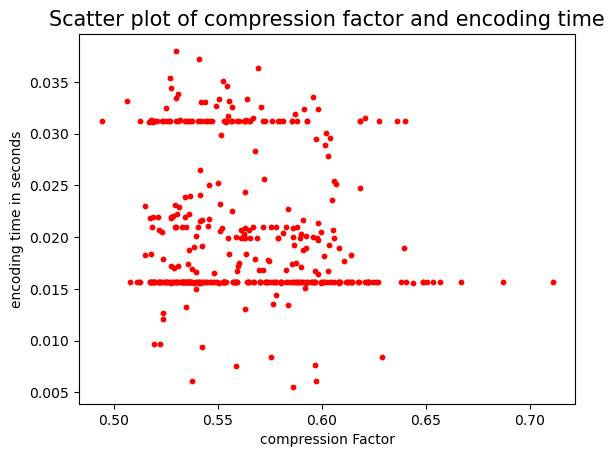

In [31]:
#Plot the compression factor on x-axis and encoder time on y-axis over all images as a scatter plot. 
fig =plt.figure(facecolor='white')
plt.scatter(compression_ratio, encoding_time, s=10, c='red', marker='o')
plt.xlabel('compression Factor', fontsize=10)
plt.ylabel('encoding time in seconds', fontsize=10)
plt.title('Scatter plot of compression factor and encoding time', fontsize=15)
plt.show()

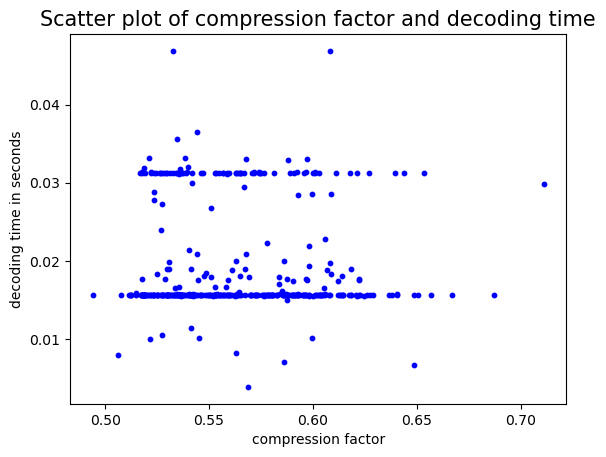

In [32]:
#Plot the compression factor on x-axis and decoder time on y-axis over all images as a scatter plot. 
fig =plt.figure(facecolor='white')
plt.scatter(compression_ratio, decoding_time, s=10, c='b', marker='o')
plt.xlabel('compression factor', fontsize=10)
plt.ylabel('decoding time in seconds', fontsize=10)
plt.title('Scatter plot of compression factor and decoding time', fontsize=15)
plt.show()